In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
np.set_printoptions(edgeitems=20, precision=3, linewidth=160)
import matplotlib.pyplot as plt
fig_width = 12
%matplotlib inline


# the switching binomial generative model


In [2]:
import bayesianchangepoint as bcp

seed = 51 #119 #2017 # 42
np.random.seed(seed)
N_blocks = 3 
N_trials = 500
max_run_length = 350
Jeffreys = False
Jeffreys = True
tau = N_trials/10.
h = 1./tau
(trials, p) = bcp.switching_binomial_motion(N_trials=N_trials, N_blocks=N_blocks, tau=tau, seed=seed, Jeffreys=Jeffreys)


p0, r0 = .5, 2. - Jeffreys
print('p0, r0 = ', p0, r0)

p0, r0 =  0.5 1.0


## performing inference: application to synthetic data

In [3]:
mode = 'expectation'

i_block= 0


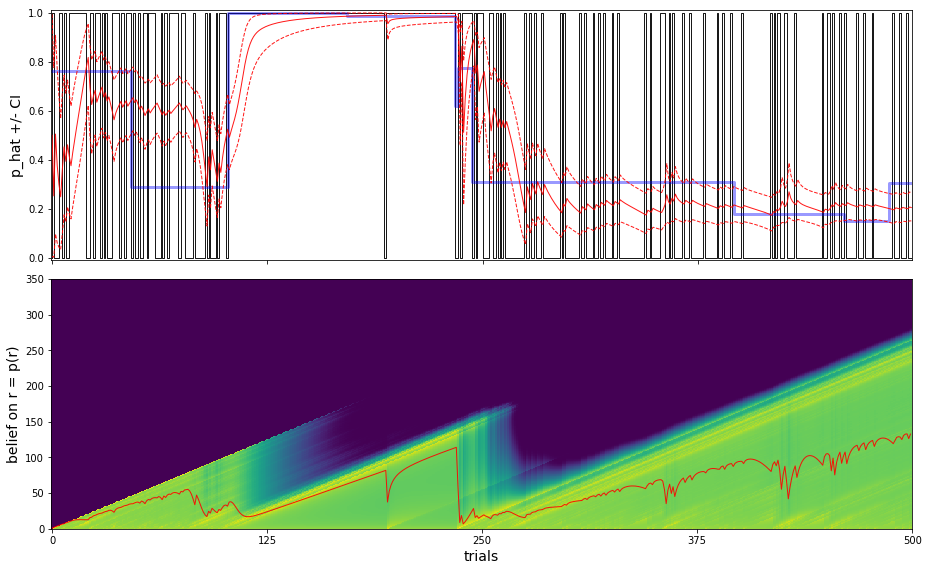

i_block= 1


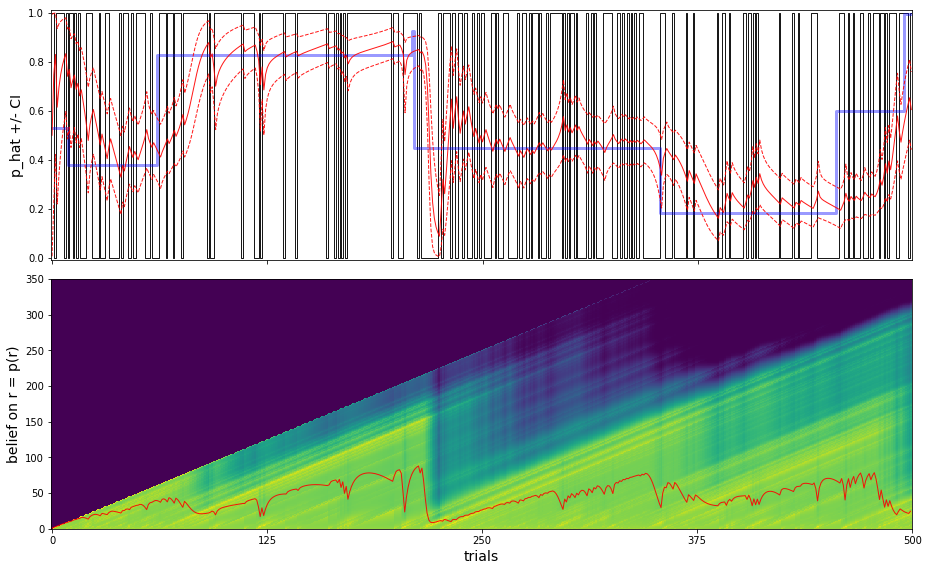

i_block= 2


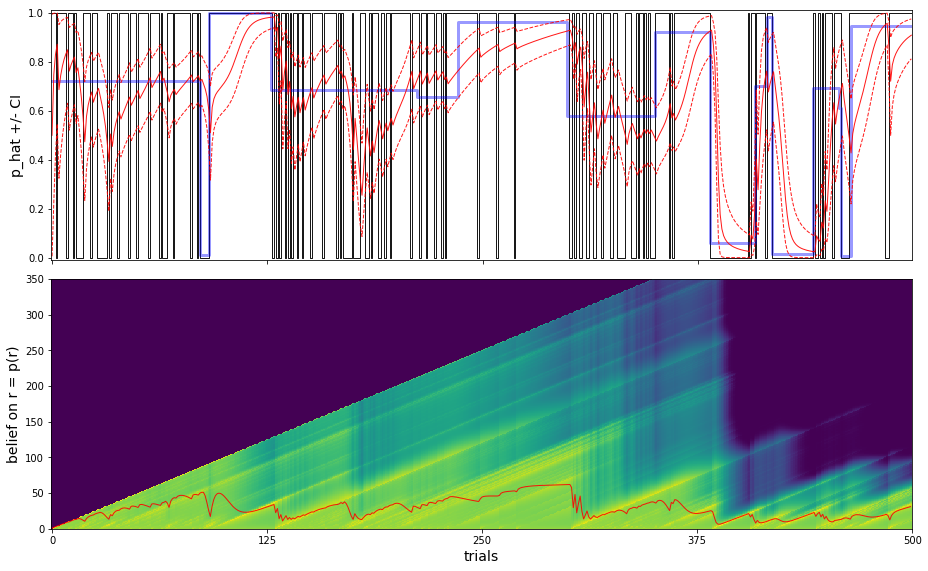

In [4]:
for i_block in range(N_blocks):
    print('i_block=', i_block)
    o = p[:, i_block, 0]
    p_bar, r, beliefs = bcp.inference(o, h=h, p0=p0, r0=r0)
    fig, axs = bcp.plot_inference(p[:, i_block, 0], p[:, i_block, 1], p_bar, r, beliefs, mode=mode, max_run_length=max_run_length)
    plt.show()

## testing different hazard rates

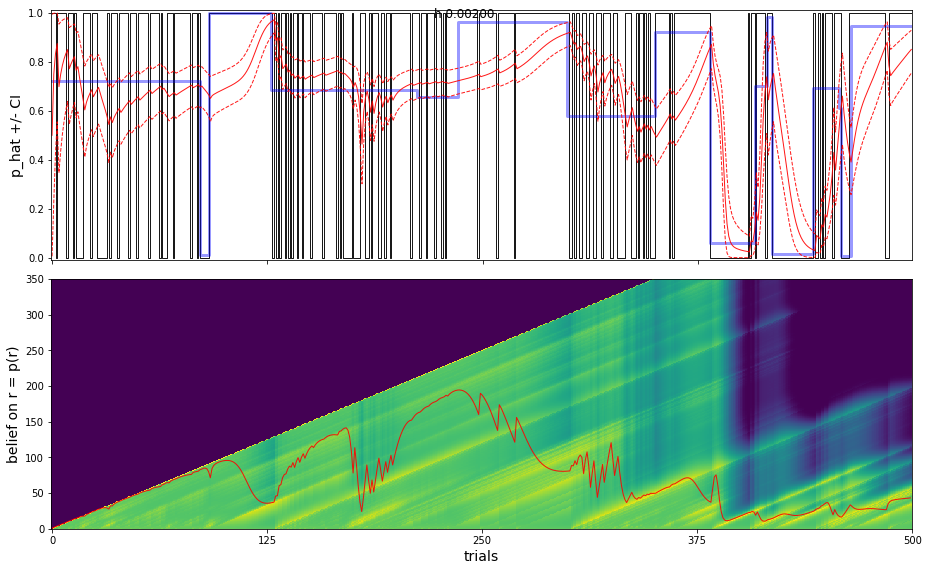

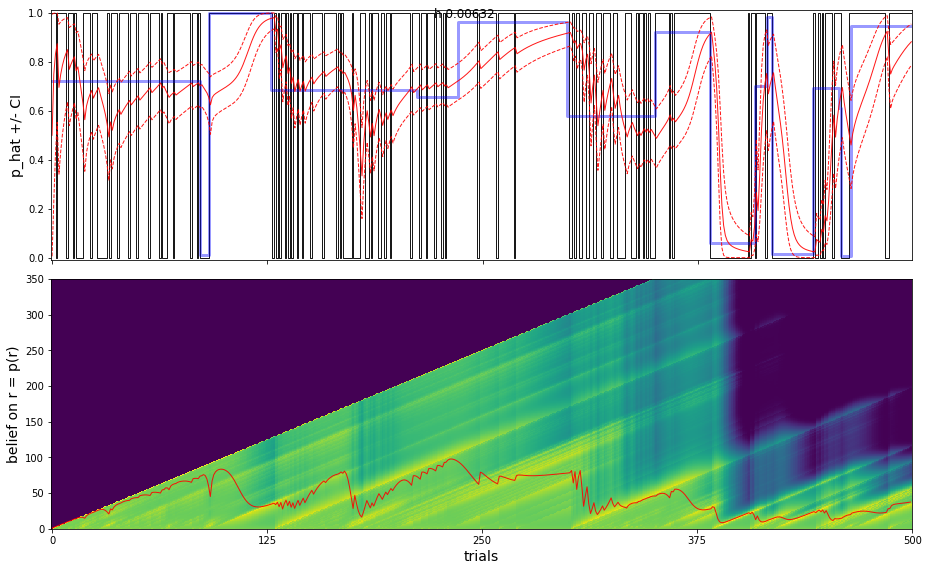

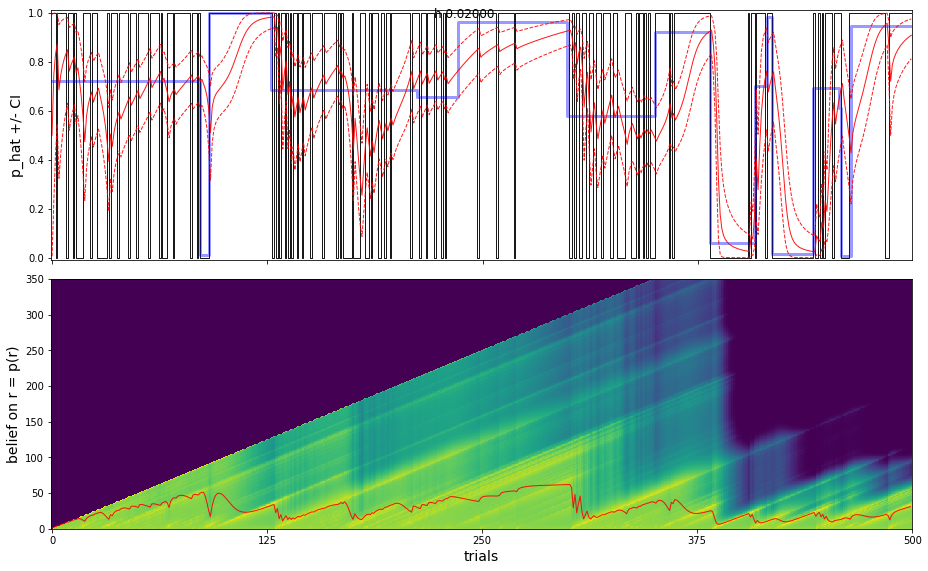

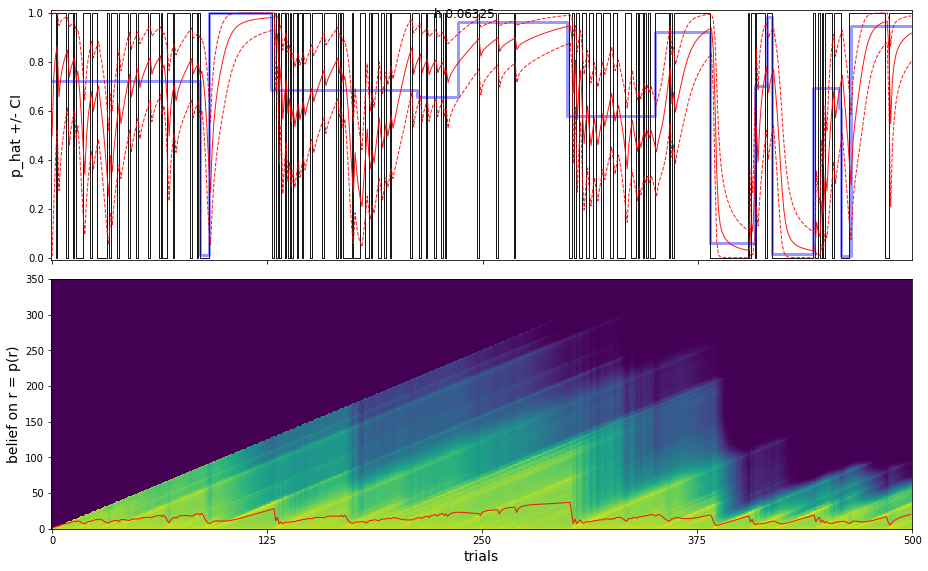

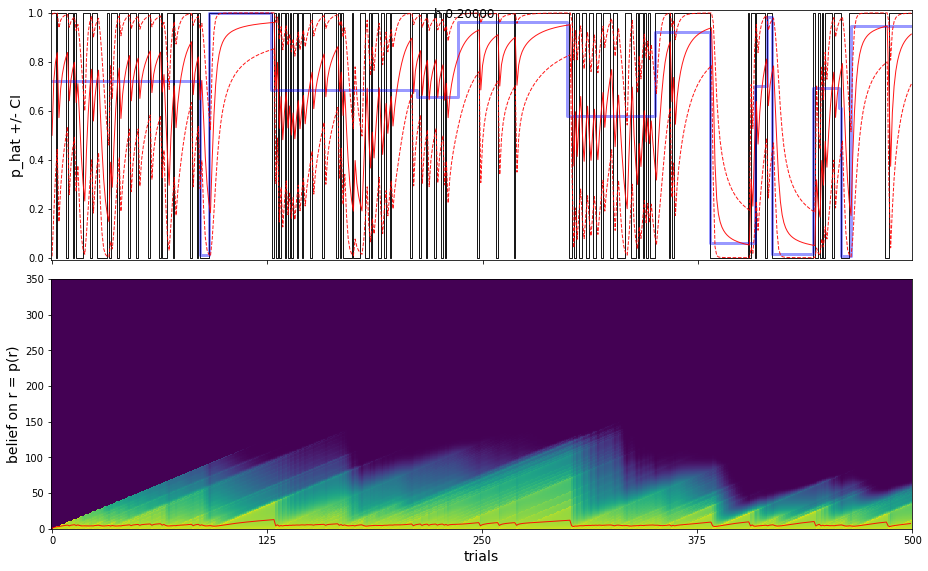

In [5]:
hs = h*np.logspace(-1., 1., 5)
for h_ in hs:
    o = p[:, i_block, 0]
    p_bar, r, beliefs = bcp.inference(o, h=h_, p0=p0, r0=r0)
    fig, axs = bcp.plot_inference(o, p[:, i_block, 1], p_bar, r, beliefs, mode=mode, max_run_length=max_run_length)
    fig.suptitle('h %.5f' % h_)
    plt.show()

## evaluating the best hazard rate using a likelihood score

In [6]:
N_scan = 15 # number of h values we test

N_blocks = 20 # number of blocks we use in our evaluation
#N_blocks = 100 # number of blocks we use in our evaluation

N_trials = 2000
tau = 40 #N_trials/5.
h = 1./tau

border = 2*tau # N_trials//10

(trials, p) = bcp.switching_binomial_motion(N_trials=N_trials, N_blocks=N_blocks, tau=tau, seed=seed, Jeffreys=Jeffreys)

hs = h*np.logspace(-2, 1, N_scan)
modes = ['expectation', 'max', 'mean', 'hindsight', 'fixed']
score = np.zeros((len(modes), N_scan, N_blocks))
for i_block in range(N_blocks):
    o = p[:, i_block, 0] # observations
    for i_scan, h_ in enumerate(hs):
        p_bar, r, beliefs = bcp.inference(o, h=h_, p0=p0, r0=r0)
        for i_mode, mode_ in enumerate(modes):
            if mode_=='fixed': 
                p_hat, r_hat = bcp.readout(p_bar, r, beliefs, mode=mode_, fixed_window_size=int(1/h_))
            else:
                p_hat, r_hat = bcp.readout(p_bar, r, beliefs, mode=mode_, p0=p0)
            #score[i_mode, i_scan, i_block] = np.sum(np.abs(p_hat - p[:, i_block, 0]))
            score[i_mode, i_scan, i_block] = np.mean(np.log2(bcp.likelihood(o[(border+1):], p_hat[border:-1], r_hat[border:-1])))
            #score[i_mode, i_scan, i_block] = np.log2(np.mean(bcp.likelihood(o[(border+1):], p_hat[border:-1], r_hat[border:-1])))
            

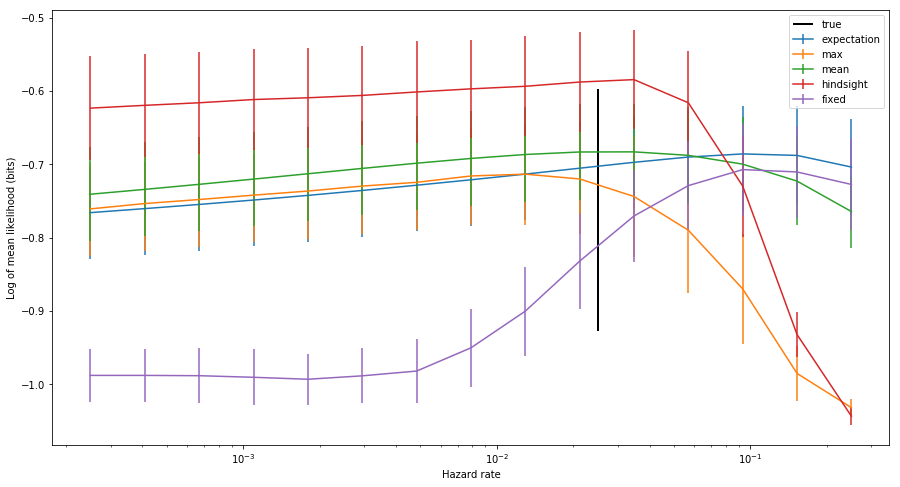

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
for i_mode, mode in enumerate(modes):
    ax.errorbar(hs, np.nanmean(score[i_mode, ...], axis=1), yerr=np.std(score[i_mode, ...], axis=1), label=mode)

ax.vlines(h, ymin=np.nanmin(np.nanmean(score, axis=(0))), ymax=np.nanmax(np.nanmean(score, axis=(0))), lw=2, label='true')
ax.set_xscale("log")#, nonposx='clip')

ax.set_xlabel('Hazard rate')
#ax.set_ylabel('Mean log-likelihood (bits)')
ax.set_ylabel('Log of mean likelihood (bits)')
ax.legend();

In [8]:
np.nanmin(score), np.nanmax(score)

(-1.0673008312595342, -0.4866881211598231)

In [9]:
np.min(score), np.max(score)

(-1.0673008312595342, -0.4866881211598231)

## evaluating the best hazard rate using a KL divergence

delay =  -1


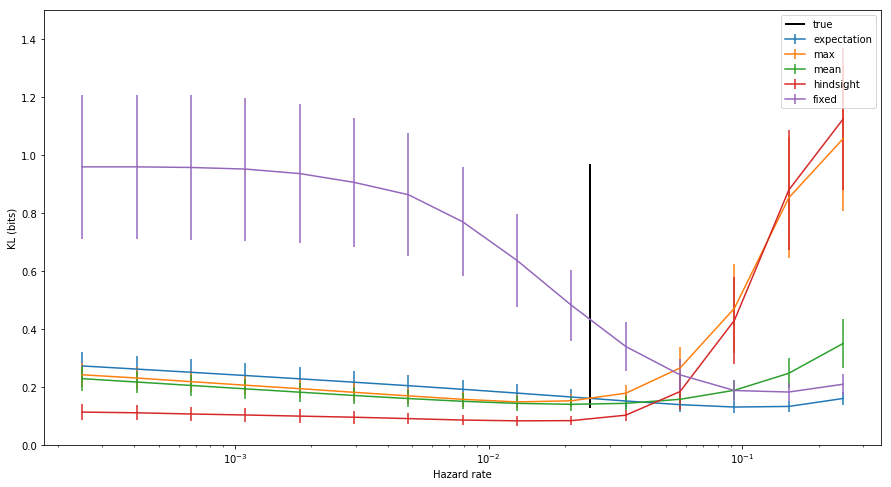

delay =  0


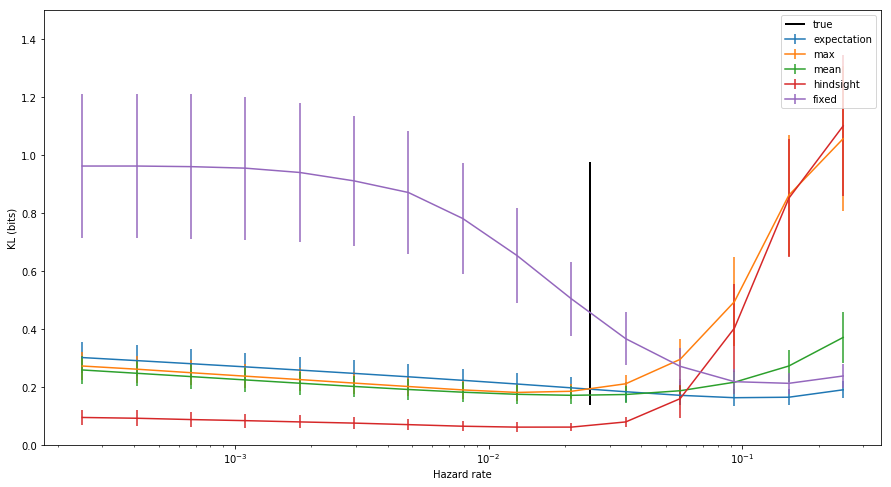

delay =  1


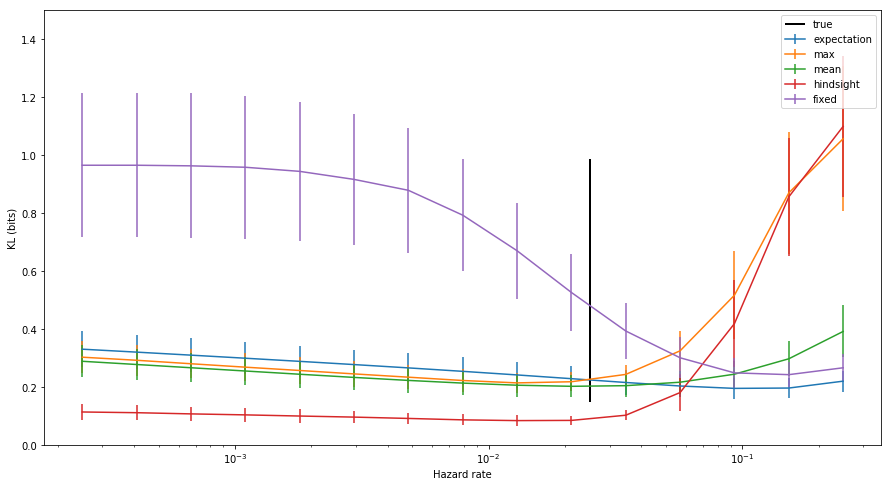

delay =  2


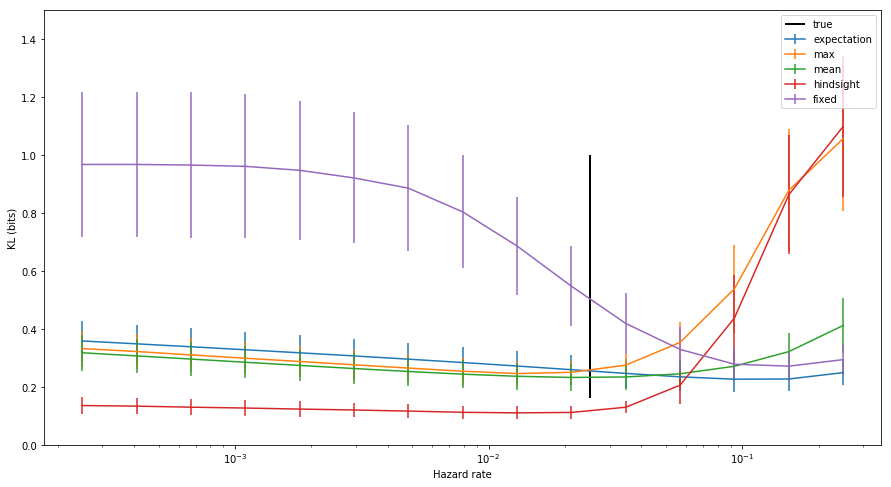

delay =  3


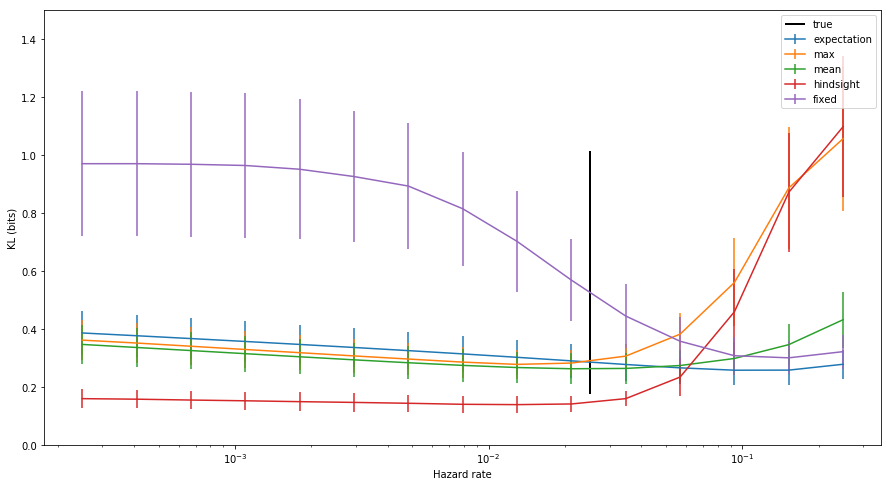

delay =  4


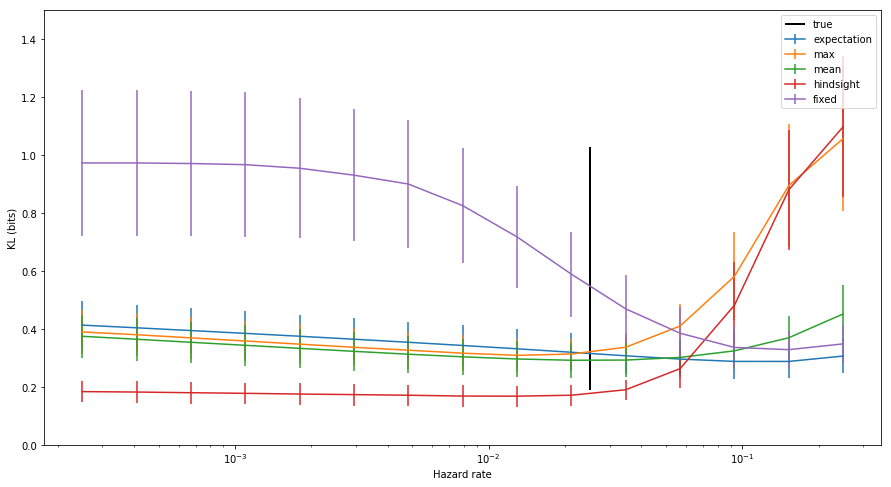

In [10]:
p0, r0 = .5, 1.

for delay in np.arange(-1, 5):
    print('delay = ', delay)
    N_scan = 15 # number of h values we test

    N_blocks = 100 # number of blocks we use in our evaluation
    #N_blocks = 20 # number of blocks we use in our evaluation
    
    N_trials = 2000
    #N_trials = 200
    tau = 40 #N_trials/5.
    h = 1./tau

    border = 2*tau # N_trials//10

    (trials, p) = bcp.switching_binomial_motion(N_trials=N_trials, N_blocks=N_blocks, tau=tau, seed=seed, Jeffreys=Jeffreys)

    hs = h*np.logspace(-2, 1, N_scan)
    modes = ['expectation', 'max', 'mean', 'hindsight', 'fixed']
    score = np.zeros((len(modes), N_scan, N_blocks))
    KL = np.zeros((len(modes), N_scan, N_blocks))
    for i_block in range(N_blocks):
        o = p[:, i_block, 0] # observations
        for i_scan, h_ in enumerate(hs):
            p_bar, r, beliefs = bcp.inference(o, h=h_, p0=p0, r0=r0)
            for i_mode, mode_ in enumerate(modes):
                if mode_=='fixed': 
                    p_hat, r_hat = bcp.readout(p_bar, r, beliefs, mode=mode_, fixed_window_size=int(1/h_))
                else:
                    p_hat, r_hat = bcp.readout(p_bar, r, beliefs, mode=mode_, p0=p0)
                    
                p_hat = np.roll(p_hat, delay)
                r_hat = np.roll(r_hat, delay)
                KL_ = p_hat * np.log2(p_hat) - p_hat * np.log2(p[:, i_block, 1])
                KL_ += (1-p_hat) * np.log2(1-p_hat) - (1-p_hat) * np.log2(1-p[:, i_block, 1])
                KL[i_mode, i_scan, i_block] = np.mean(KL_)
                score[i_mode, i_scan, i_block] = np.mean(np.log2(bcp.likelihood(o[(border+1):], p_hat[border:-1], r_hat[border:-1])))
                #score[i_mode, i_scan, i_block] = np.log2(np.mean(bcp.likelihood(o[(border+1):], p_hat[border:-1], r_hat[border:-1])))

    if True:
        fig, ax = plt.subplots(1, 1, figsize=(15, 8))
        for i_mode, mode in enumerate(modes):
            ax.errorbar(hs, np.nanmean(score[i_mode, ...], axis=1), yerr=np.std(score[i_mode, ...], axis=1), label=mode)

        ax.vlines(h, ymin=np.nanmin(np.nanmean(score, axis=(0))), ymax=np.nanmax(np.nanmean(score, axis=(0))), lw=2, label='true')
        ax.set_xscale("log")#, nonposx='clip')

        ax.set_xlabel('Hazard rate')
        #ax.set_ylabel('Mean log-likelihood (bits)')
        ax.set_ylabel('Log of mean likelihood (bits)')
        ax.legend();
    
    if False:
        fig, ax = plt.subplots(1, 1, figsize=(15, 8))
        for i_mode, mode in enumerate(modes):
            ax.errorbar(hs, np.nanmean(KL[i_mode, ...], axis=1), yerr=np.std(KL[i_mode, ...], axis=1), label=mode)

        ax.vlines(h, ymin=np.nanmin(np.nanmean(KL, axis=(0))), ymax=np.nanmax(np.nanmean(KL, axis=(0))), lw=2, label='true')
        ax.set_xscale("log")#, nonposx='clip')

        ax.set_xlabel('Hazard rate')
        #ax.set_ylabel('Mean log-likelihood (bits)')
        ax.set_ylim(0, 1.5)
        ax.set_ylabel('KL (bits)')
        ax.legend();
    plt.show()